In [9]:
import autograd.numpy as np
from autograd import jacobian
from numpy import genfromtxt
import scipy
from scipy.optimize import Bounds
import matplotlib.pyplot as plt

# GOH
Gasser et al 2006(https://doi.org/10.1098/rsif.2005.0073)


Incompressible material assumption
$$\Psi_1(J) = p(1-J)$$
$$\Psi_2(\mathbf{C}) = \frac{\mu}{2}(I_1 -3) +\frac{k_1}{2k_2}[e^{(k_2[\kappa I_1 + (1-3\kappa)I_4-1]^2)}-1]$$
Here $I_4 = \mathbf{C}:\mathbf{M} =\mathbf{C}:  \mathbf{a}_0\otimes \mathbf{a}_0$

Let $\mathbf{H} =\kappa I_1 + (1-3\kappa)I_4$ and $\mathbf{E} = [\mathbf{H}-1]$

$$\mathbf{S}_1  = 2\frac{\partial \Psi_{1}}{\partial \mathbf{C}} = -pC^{-1} $$
$$\mathbf{S}_2  =  2\frac{\partial \Psi_{2}}{\partial \mathbf{C}} = \mu \mathbf{I} + 2k_1 e^{k_2\mathbf{E}^2}\mathbf{E}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK2 stress

$$\mathbf{S} = -p\mathbf{C}^{-1} +  \mu\mathbf{I} + 2k_1 e^{k_2\mathbf{E}^2}\mathbf{E}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK1 stress

$$\mathbf{P} = \mathbf{F}\mathbf{S}$$

In [10]:
def evalsigma(par,lam1,lam2):
    mu = par[0]
    k1 = par[1]
    k2 = par[2]
    kappa = par[3]
    alpha = par[4]
    
    #Structure tensor
    a0 = np.array([np.cos(alpha),np.sin(alpha),0])
    M = np.outer(a0,a0)
    
    #Kinematics
    lam3 = 1/(lam1*lam2)
    F = np.array([[(lam1) ,0., 0],[0.,(lam2), 0] ,[0., 0,(lam3)]])
#     C = np.array([[lam1 ,0, 0],[0,lam2, 0] ,[0, 0, lam3]])
    C = F.T*F
    invF = np.linalg.inv(F)
    invC = np.linalg.inv(C)
    I = np.eye(3)
    
    #Invariants
    I1 = np.trace(C)
    I4 = np.tensordot(C,M)
    
    
    #Evaluate stress
    H = kappa*I1+(1-3*kappa)*I4
    E = H-1
    S2 = mu*I+2*k1*np.exp(k2*E**2)*E*(kappa*I+(1-3*kappa)*M)
    p = S2[2,2]/invC[2,2] #Get pressure  by equating S_33=0
    S = -p*invC+S2
    
#     print(p)
    
    sigma =  F*S*F
    return sigma

# Import all relevant data and form data frames

Visualize data here to insepct. Correct the files before proceeding to fitting

In [11]:
#path ="../Stress_Stretch_Control/"
Exp1 = "Subject111_Sample4_YoungDorsal_"
A_Offx = Exp1+"OffbiaxialX.csv"
A_Offy = Exp1+"OffbiaxialY.csv"
A_Equi = Exp1+"Equibiaxial.csv"

In [12]:
AX = genfromtxt(A_Offx,delimiter=',')
AY = genfromtxt(A_Offy,delimiter=',')
AE = genfromtxt(A_Equi,delimiter=',')
A = np.vstack([AX,AY,AE])

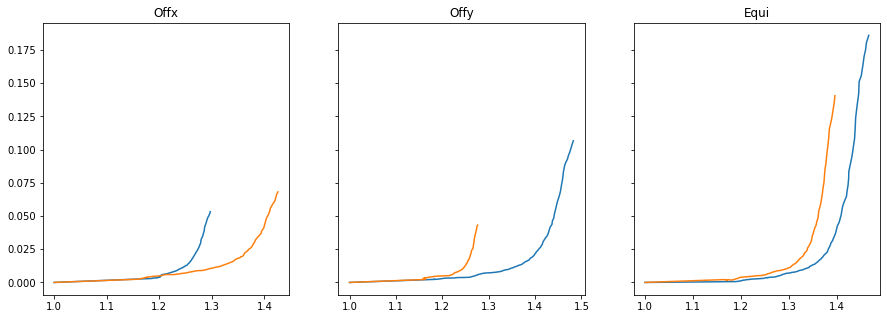

In [13]:
fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
ax[0].plot(AX[:,0],AX[:,2])
ax[0].plot(AX[:,1],AX[:,3])
ax[0].set_title("Offx")
ax[1].plot(AY[:,0],AY[:,2])
ax[1].plot(AY[:,1],AY[:,3])
ax[1].set_title("Offy")
ax[2].plot(AE[:,0],AE[:,2])
ax[2].plot(AE[:,1],AE[:,3])
ax[2].set_title("Equi")
plt.show()

## Objective function for fitting 

In [14]:
def ObjA(par):  
    err = 0.0 
    lam1 = A[:,0]
    lam2 = A[:,1]
    sigmaE1 = A[:,2]
    sigmaE2 = A[:,3]
    #Evaluate the stress and calculate error
    for i in range(0,len(lam1)):
        sigma = evalsigma(par,lam1[i],lam2[i])
        err += (sigma[0,0]-sigmaE1[i])**2+ (sigma[1,1]-sigmaE2[i])**2  
    return np.sqrt(err)/len(lam1)
jacA = jacobian(ObjA) # Jacobian of the objctive function using Autograd

par = [5.70088953e-04, 2.96284243e-02, 1.14909821e+01, 3.17730597e-01, 5.29349083e-03]
# par = [1,1,1,1/6,np.pi/4] #Intial guess for the optimizer
bounds = Bounds([0.0,0.0,0.0,0.,-np.pi/2],[10.,10.,1000.,1/3,np.pi/2] ) #Bounds on parameters

### Run the optimizer and inspect the results

In [15]:
optA = scipy.optimize.minimize(ObjA,par,jac=jacA,bounds = bounds)
print("Optim for A ",optA.x)

Optim for A  [7.91398920e-04 2.37871824e-02 1.14908848e+01 3.22492282e-01
 5.29430919e-03]


#### Plot

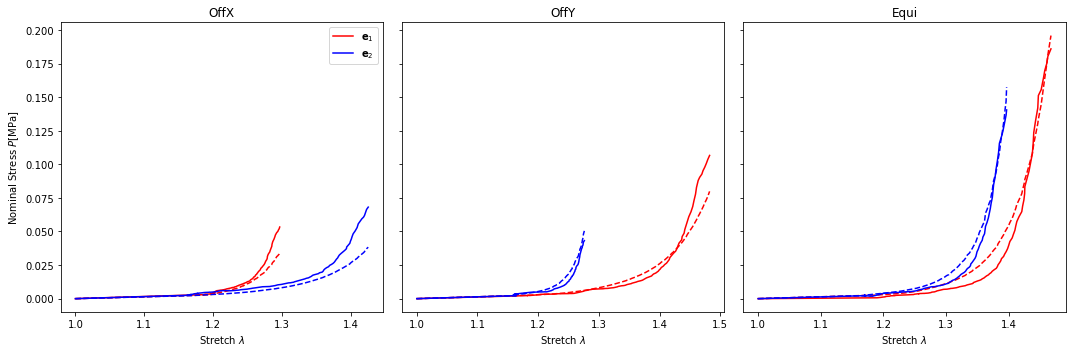

In [16]:
fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)

lam1_1 = AX[:,0]
lam1_2 = AX[:,1]
sigmaE1_1 = AX[:,2]
sigmaE1_2 = AX[:,3]
sigmaarr1 = np.zeros([len(lam1_1),2])
for i in range(0,len(lam1_1)):
        sigma = evalsigma(optA.x,lam1_1[i],lam1_2[i])
        sigmaarr1[i,0] = sigma[0,0]
        sigmaarr1[i,1] = sigma[1,1]

        
lam2_1 = AY[:,0]
lam2_2 = AY[:,1]
sigmaE2_1 = AY[:,2]
sigmaE2_2 = AY[:,3]
sigmaarr2 = np.zeros([len(lam2_1),2])
for i in range(0,len(lam2_1)):
        sigma = evalsigma(optA.x,lam2_1[i],lam2_2[i])
        sigmaarr2[i,0] = sigma[0,0]
        sigmaarr2[i,1] = sigma[1,1]

lam3_1 = AE[:,0]
lam3_2 = AE[:,1]
sigmaE3_1 = AE[:,2]
sigmaE3_2 = AE[:,3]
sigmaarr3 = np.zeros([len(lam3_1),2])
for i in range(0,len(lam3_1)):
        sigma = evalsigma(optA.x,lam3_1[i],lam3_2[i])
        sigmaarr3[i,0] = sigma[0,0]
        sigmaarr3[i,1] = sigma[1,1]
        
ax[0].plot(lam1_1,sigmaE1_1,color='r',label=r'$\mathbf{e}_1$')       
ax[0].plot(lam1_1,sigmaarr1[:,0],'--',color='r')
ax[0].plot(lam1_2,sigmaE1_2,color='b',label=r'$\mathbf{e}_2$')       
ax[0].plot(lam1_2,sigmaarr1[:,1],'--',color='b') 
ax[0].set_title("OffX")
ax[0].set_xlabel(r'Stretch $\lambda$')
ax[0].set_ylabel(r'Nominal Stress $P$[MPa]')
ax[0].legend()

ax[1].plot(lam2_1,sigmaE2_1,color='r',label=r'$\mathbf{e}_1$')       
ax[1].plot(lam2_1,sigmaarr2[:,0],'--',color='r')
ax[1].plot(lam2_2,sigmaE2_2,color='b',label=r'$\mathbf{e}_2$')       
ax[1].plot(lam2_2,sigmaarr2[:,1],'--',color='b')  
ax[1].set_title("OffY")
ax[1].set_xlabel(r'Stretch $\lambda$')
# ax[1].set_ylabel(r'Nominal Stress $P$[MPa]')


ax[2].plot(lam3_1,sigmaE3_1,color='r',label=r'$\mathbf{e}_1$')       
ax[2].plot(lam3_1,sigmaarr3[:,0],'--',color='r')
ax[2].plot(lam3_2,sigmaE3_2,color='b',label=r'$\mathbf{e}_2$')       
ax[2].plot(lam3_2,sigmaarr3[:,1],'--',color='b')  
ax[2].set_title("Equi")
ax[2].set_xlabel(r'Stretch $\lambda$')
# ax[2].set_ylabel(r'Nominal Stress $P$[MPa]')

plt.tight_layout()
plt.savefig("Img/"+Exp1+".png",dpi=300)
plt.show()
